# Process the raw Rio de Janeiro magnetic data

The data come in a bad text format and there is some cleaning and processing that we need to do:

1. Convert to standard CSV for easier reading with Pandas.
2. Add projected easting and northing coordinates using a Mercator projection instead of the UTM coordinates given in 2 different zones.
3. Remove the tie lines since they seem to be a bit bad.
4. Crop the data to a smaller area with some interesting anomalies.
5. Calculate derivatives of the line data using equivalent sources.

In [1]:
import pathlib
import tarfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyproj
import verde as vd
import harmonica as hm

## Load the data

In [2]:
data_dir = pathlib.Path("..") / "data"

In [3]:
data_path = data_dir / "1038_XYZ.tar.xz"
with tarfile.open(data_path) as archive:
    with archive.extractfile("1038_XYZ/1038/spaulo_rjaneiro_rj.xyz") as data_file:
        raw_data = []
        usecols = [2, 3, 4, 18]        
        read_data = False
        for i, line in enumerate(data_file):
            line = line.decode("latin1")
            if i < 5:
                continue
            if line.strip().startswith("LINE"):
                line_no = int(line.strip().split()[-1][:-1])
                read_data = True
                continue
            # Skip the tie lines because some of them are bad
            if line.strip().startswith("TIE"):
                read_data = False
                continue
            if read_data:
                columns = [float(c.strip()) for c in line.strip().split()]
                raw_data.append([columns[c] for c in usecols] + [line_no])
    full_data = pd.DataFrame(
        raw_data,
        columns=[
            "longitude", 
            "latitude", 
            "total_field_anomaly_nT", 
            "altitude_m",
            "line_number",
        ],
    )
full_data

,longitude,latitude,total_field_anomaly_nT,altitude_m,line_number
0,-43.995285,-23.100388,444.36,300.00,20
1,-43.995255,-23.099503,434.32,300.00,20
2,-43.995224,-23.098618,426.28,300.00,20
3,-43.995193,-23.097733,418.24,300.00,20
4,-43.995178,-23.096832,410.20,300.00,20
...,...,...,...,...,...
393290,-40.966003,-21.270996,11.26,143.87,6500
393291,-40.965988,-21.270111,13.17,143.87,6500
393292,-40.965988,-21.269211,11.08,143.87,6500
393293,-40.965973,-21.268311,11.00,143.87,6500


## Crop the data to a better region

In [4]:
region = [-42.64, -41.9, -22.6, -22]
data = full_data.loc[vd.inside((full_data.longitude, full_data.latitude), region)].reset_index(drop=True).copy()
data

,longitude,latitude,total_field_anomaly_nT,altitude_m,line_number
0,-42.639984,-22.290527,-16.56,151.49,2800
1,-42.639969,-22.291397,-43.47,162.46,2800
2,-42.639954,-22.292267,-65.38,170.69,2800
3,-42.639938,-22.293152,-74.29,173.43,2800
4,-42.639923,-22.294022,-67.20,170.08,2800
...,...,...,...,...,...
50877,-41.905685,-22.497009,163.33,143.87,4600
50878,-41.905685,-22.497879,175.29,142.34,4600
50879,-41.905701,-22.498734,180.25,140.51,4600
50880,-41.905701,-22.499588,175.21,138.68,4600


## Project the coordinates

In [5]:
projection = pyproj.Proj(proj="merc", lat_ts=data.latitude.mean())
data = data.assign(**{
    name: coord 
    for name, coord in zip(
        ["easting_m", "northing_m"], projection(data.longitude, data.latitude)
    )
})
data

,longitude,latitude,total_field_anomaly_nT,altitude_m,line_number,easting_m,northing_m
0,-42.639984,-22.290527,-16.56,151.49,2800,-4.393928e+06,-2.342215e+06
1,-42.639969,-22.291397,-43.47,162.46,2800,-4.393926e+06,-2.342311e+06
2,-42.639954,-22.292267,-65.38,170.69,2800,-4.393925e+06,-2.342407e+06
3,-42.639938,-22.293152,-74.29,173.43,2800,-4.393923e+06,-2.342505e+06
4,-42.639923,-22.294022,-67.20,170.08,2800,-4.393922e+06,-2.342602e+06
...,...,...,...,...,...,...,...
50877,-41.905685,-22.497009,163.33,143.87,4600,-4.318260e+06,-2.365096e+06
50878,-41.905685,-22.497879,175.29,142.34,4600,-4.318260e+06,-2.365192e+06
50879,-41.905701,-22.498734,180.25,140.51,4600,-4.318262e+06,-2.365287e+06
50880,-41.905701,-22.499588,175.21,138.68,4600,-4.318262e+06,-2.365382e+06


## Calculate derivatives

In [6]:
%%time
eqs = hm.EquivalentSourcesGB(
    damping=1e1, depth=1000, block_size=100, random_state=42,
)
coordinates = (data.easting_m, data.northing_m, data.altitude_m)
eqs.fit(coordinates, data.total_field_anomaly_nT)

/home/leo/miniforge3/envs/euler-inversion/lib/python3.12/site-packages/harmonica/_equivalent_sources/gradient_boosted.py:224: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  data = data.ravel()


/home/leo/miniforge3/envs/euler-inversion/lib/python3.12/site-packages/verde/blockreduce.py:179: FutureWarning: The provided callable <function median at 0x74cbdabd8a40> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  blocked = pd.DataFrame(columns).groupby("block").aggregate(reduction)
/home/leo/miniforge3/envs/euler-inversion/lib/python3.12/site-packages/verde/blockreduce.py:236: FutureWarning: The provided callable <function median at 0x74cbdabd8a40> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  grouped = table.groupby("block").aggregate(self.reduction)


CPU times: user 11min 48s, sys: 18.4 s, total: 12min 6s
Wall time: 2min 36s


EquivalentSourcesGB(block_size=100, damping=10.0, depth=1000, random_state=42)

In [7]:
delta = 5
data["deriv_up"] = (
    eqs.predict((data.easting_m, data.northing_m, data.altitude_m + delta))
    - eqs.predict((data.easting_m, data.northing_m, data.altitude_m - delta))
) / (2 * delta)
data["deriv_east"] = (
    eqs.predict((data.easting_m + delta, data.northing_m, data.altitude_m))
    - eqs.predict((data.easting_m - delta, data.northing_m, data.altitude_m))
) / (2 * delta)
data["deriv_north"] = (
    eqs.predict((data.easting_m, data.northing_m + delta, data.altitude_m))
    - eqs.predict((data.easting_m, data.northing_m - delta, data.altitude_m))
) / (2 * delta)

## Plot the data and derivatives

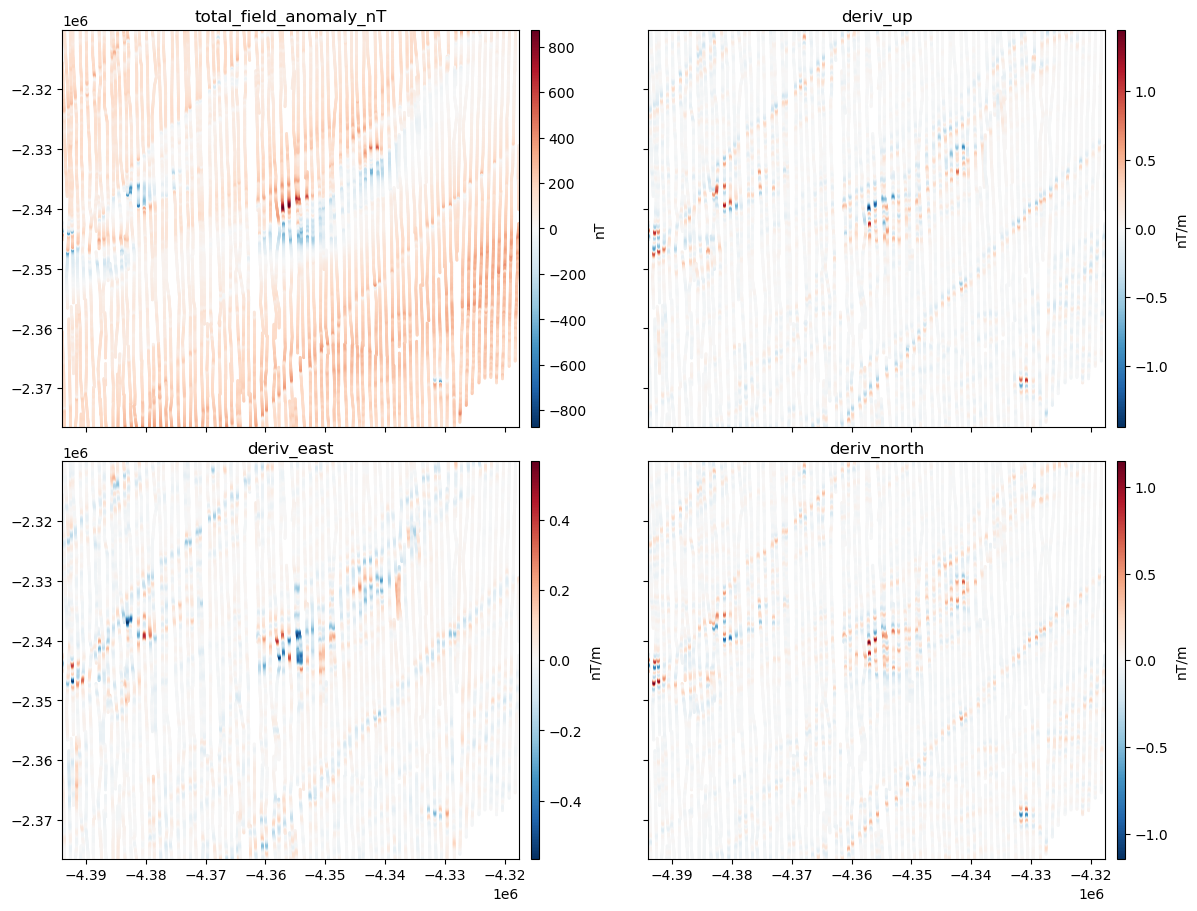

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(12, 9), sharex=True, sharey=True, layout="constrained")
for ax in axes.ravel():
    ax.set_aspect("equal")
    ax.set_xlim(data.easting_m.min(), data.easting_m.max())
    ax.set_ylim(data.northing_m.min(), data.northing_m.max())

variables = [
    "total_field_anomaly_nT",
    "deriv_up",
    "deriv_east",
    "deriv_north",
]
units = ["nT", "nT/m", "nT/m", "nT/m"]
for ax, var, unit in zip(axes.ravel(), variables, units):
    scale = vd.maxabs(data[var])
    ax.set_title(var)
    tmp = ax.scatter(data.easting_m, data.northing_m, s=1, c=data[var], vmin=-scale, vmax=scale, cmap="RdBu_r")
    fig.colorbar(tmp, ax=ax, label=unit, aspect=50, pad=0.01, orientation="vertical")
plt.show()

## Export to CSV

In [9]:
data.to_csv(data_dir / "rio-de-janeiro-magnetic.csv", index=False)